In [1]:
# -!- coding: utf-8 -!-
## load library
%matplotlib inline

import pandas as pd
import numpy as np
import gensim
from gensim.models import word2vec, Word2Vec
from scipy import stats
import matplotlib.pyplot as plt
from wordcloud import WordCloud

FONT_PATH = './util_files/font/simkai.ttf'

import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action = 'ignore')

import csv, os, sys, math
import linecache
import pickle
import random
import datetime

#簡轉繁用 
#https://pypi.python.org/pypi/hanziconv/0.2.1
from hanziconv import HanziConv 

#https://stackoverflow.com/questions/14519177/python-exception-handling-line-number
def PrintException():
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    filename = f.f_code.co_filename
    linecache.checkcache(filename)
    line = linecache.getline(filename, lineno, f.f_globals)
    print ('EXCEPTION IN ({}, LINE {} "{}"): {}'.format(filename, lineno, line.strip(), exc_obj))

In [2]:
# READ TAIWAN DATA
taiwandata = pd.read_csv('./NameData/TaiwanDataset.csv', parse_dates = True)

In [3]:
taiwandata.head()

,C_Name,E_Name,Gender,Year,CN_Surname,CN_Firstname,EN_Surname,EN_Firstname
0,紀明德,Ming-Te Chi,M,1978,紀,明德,Chi,Ming-Te
1,胡毓忠,Yuh-Jong Hu,M,1958,胡,毓忠,Hu,Yuh-Jong
2,郭桐惟,Tung-Wei Kuo,M,1987,郭,桐惟,Kuo,Tung-Wei
3,張宏慶,Hung-Ching Jang,M,1962,張,宏慶,Jang,Hung-Ching
4,廖文宏,Wen-Hung Liao,M,1965,廖,文宏,Liao,Wen-Hung


In [4]:
#Read files

with open('./pkl_data/special_word_dict', 'rb') as handle:
    special_word_dict = pickle.loads(handle.read())

with open('./pkl_data/radical_list', 'rb') as handle:
    radical_list = pickle.loads(handle.read())

with open('./pkl_data/Totalname_list', 'rb') as handle:
    Totalname_list = pickle.loads(handle.read())
    
with open('./pkl_data/son_in_list', 'rb') as handle:
    son_in_list = pickle.loads(handle.read())
     
with open('./pkl_data/mu_in_list', 'rb') as handle:
    mu_in_list = pickle.loads(handle.read())

In [5]:
#Read uni-gram classifier
with open('./pkl_data/Character_feature_dic', 'rb') as handle:
    Character_feature_dic = pickle.loads(handle.read())
    
def checkPronoun(word, mode):
    #mode 1 = sonin
    #mode 2 = muin
    vowel = ['A', 'E', 'I', 'O', 'U', 'a', 'e', 'i', 'o', 'u']
    result = ''
    
    for len_word in word.split(): 
        con = ''
        vow = ''
        length = len(len_word)

        for index in range(length):
            current = len_word[index]
            if current not in vowel:
                con += current
               
            else:
                vow = len_word[index:]  
                break
                
    if mode == 'sonin':
        if len(word) >= 1:
            return con
        else:
            return -1

    elif mode == 'muin':
        if len(word) >= 1:
            return vow
        else:
            return -1

def add_pin_in_index_column(pin_yin, mode):
    #mode 1 = sonin
    #mode 2 = muin
    if pin_yin == None:
        return -1
    try:
        if mode == 'muin':
            if pin_yin in mu_in_list:
                return mu_in_list.index(pin_yin)
            else:
                mu_in_list.append(pin_yin)
                return mu_in_list.index(pin_yin)

        if mode == 'sonin':
            if pin_yin in son_in_list:
                return son_in_list.index(pin_yin)
            else:
                son_in_list.append(pin_yin)
                return son_in_list.index(pin_yin)

    except Exception as e:
        print (e)
        print (fileName)
        PrintException() 

def character_to_index(name,n):
    if n == 1:
        if name[0] in Totalname_list:
            return Totalname_list.index(name[0])
        else:
            Totalname_list.append(name[0])
            return Totalname_list.index(name[0])
    if n == 2 and len(name) == 2:
        if name[1] in Totalname_list:
            return Totalname_list.index(name[1])
        else:
            Totalname_list.append(name[1])
            return Totalname_list.index(name[1])
    return -1

def gender_index(gender):
    if gender == 'M':
        return 1
    elif gender == 'F':
        return 0

In [6]:
def separateFN(FN):
    if '-' in FN:
        return FN.split('-')
    else:
        FN = '-' + FN
        return FN.split('-')

In [7]:
taiwandata = taiwandata.drop('CN_Surname', 1)
taiwandata = taiwandata.drop('CN_Firstname', 1)

taiwandata['EN_Firstname'] = taiwandata.EN_Firstname.apply(lambda x: separateFN(x))

taiwandata['Age'] = 2019 - taiwandata['Year']
taiwandata['Gender_index'] = taiwandata.Gender.apply(lambda x: gender_index(x))

taiwandata['FirstName1'] = taiwandata.EN_Firstname.apply(lambda x: x[0])
taiwandata['FirstName2'] = taiwandata.EN_Firstname.apply(lambda x: x[1])

taiwandata['FN1'] = taiwandata.EN_Firstname.apply(lambda x: character_to_index(x,1))
taiwandata['FN2'] = taiwandata.EN_Firstname.apply(lambda x: character_to_index(x,2))

taiwandata['EN_Firstname'] = taiwandata['FirstName1']  + ' ' + taiwandata['FirstName2'].apply(lambda x: x)

taiwandata['FN1_sonin'] = taiwandata.FirstName1.apply(lambda x: checkPronoun(x,'sonin'))
taiwandata['FN1_muin'] = taiwandata.FirstName1.apply(lambda x: checkPronoun(x,'muin'))

taiwandata['FN2_sonin'] = taiwandata.FirstName2.apply(lambda x: checkPronoun(x,'sonin'))
taiwandata['FN2_muin'] = taiwandata.FirstName2.apply(lambda x: checkPronoun(x,'muin'))
    
taiwandata['FN1_sonin_index'] = taiwandata.FN1_sonin.apply(lambda x: add_pin_in_index_column(x,'sonin'))
taiwandata['FN2_sonin_index'] = taiwandata.FN2_sonin.apply(lambda x: add_pin_in_index_column(x,'sonin'))

taiwandata['FN1_muin_index'] = taiwandata.FN1_muin.apply(lambda x: add_pin_in_index_column(x,'muin'))
taiwandata['FN2_muin_index'] = taiwandata.FN2_muin.apply(lambda x: add_pin_in_index_column(x,'muin'))

In [8]:
taiwandata['FN1_muin'] = taiwandata['FN1_muin'].fillna(-1)
taiwandata['FN1_sonin'] = taiwandata['FN1_sonin'].fillna(-1)

taiwandata['FN2_muin'] = taiwandata['FN2_muin'].fillna(-1)
taiwandata['FN2_sonin'] = taiwandata['FN2_sonin'].fillna(-1)


In [9]:
taiwandata.head()

,C_Name,E_Name,Gender,Year,EN_Surname,EN_Firstname,Age,Gender_index,FirstName1,FirstName2,FN1,FN2,FN1_sonin,FN1_muin,FN2_sonin,FN2_muin,FN1_sonin_index,FN2_sonin_index,FN1_muin_index,FN2_muin_index
0,紀明德,Ming-Te Chi,M,1978,Chi,Ming Te,41,1,Ming,Te,8578,8830,M,ing,T,e,55,57,22,142
1,胡毓忠,Yuh-Jong Hu,M,1958,Hu,Yuh Jong,61,1,Yuh,Jong,8579,8844,Y,uh,J,ong,56,61,168,23
2,郭桐惟,Tung-Wei Kuo,M,1987,Kuo,Tung Wei,32,1,Tung,Wei,8580,8639,T,ung,W,ei,57,59,169,60
3,張宏慶,Hung-Ching Jang,M,1962,Jang,Hung Ching,57,1,Hung,Ching,8581,8620,H,ung,Ch,ing,58,62,169,22
4,廖文宏,Wen-Hung Liao,M,1965,Liao,Wen Hung,54,1,Wen,Hung,8582,8581,W,en,H,ung,59,58,76,169


In [10]:
#每5年一區間的欄位
def year_to_range(start, rang, year):
    y = int((year - start) / rang)
    #2010
    if y == 22:
        y = 21
    return y

In [11]:
taiwandata['YearRange'] = taiwandata['Year'].apply(lambda x: year_to_range(1900, 5, x))
# taiwandata['YearRange'].value_counts()

In [12]:
for i in range(22):
    print(i)
    print(1900 + 5 * i, '~', 1904 + 5 * i)
    YearTotalName_len = len(taiwandata[taiwandata['YearRange'].apply(lambda x: x == i)])
    print('Year total name:', YearTotalName_len,'\n')

0
1900 ~ 1904
Year total name: 1 

1
1905 ~ 1909
Year total name: 0 

2
1910 ~ 1914
Year total name: 0 

3
1915 ~ 1919
Year total name: 1 

4
1920 ~ 1924
Year total name: 2 

5
1925 ~ 1929
Year total name: 3 

6
1930 ~ 1934
Year total name: 5 

7
1935 ~ 1939
Year total name: 5 

8
1940 ~ 1944
Year total name: 6 

9
1945 ~ 1949
Year total name: 18 

10
1950 ~ 1954
Year total name: 57 

11
1955 ~ 1959
Year total name: 83 

12
1960 ~ 1964
Year total name: 82 

13
1965 ~ 1969
Year total name: 102 

14
1970 ~ 1974
Year total name: 100 

15
1975 ~ 1979
Year total name: 107 

16
1980 ~ 1984
Year total name: 111 

17
1985 ~ 1989
Year total name: 111 

18
1990 ~ 1994
Year total name: 82 

19
1995 ~ 1999
Year total name: 71 

20
2000 ~ 2004
Year total name: 49 

21
2005 ~ 2009
Year total name: 6 



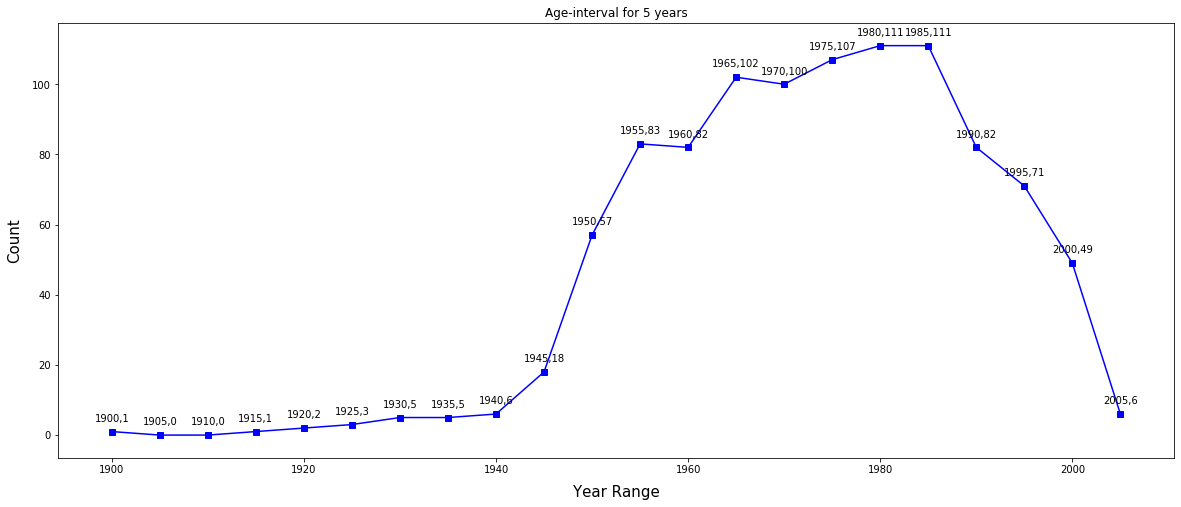

In [13]:
YearRange = []
for i in range(22):
    YearRange.append(len(taiwandata[taiwandata.YearRange.apply(lambda x: x == i)]))
    
x = [1900 + x * 5 for x in range(len(YearRange))]
y = YearRange

plt.figure(figsize = (20,8))
plt.plot(x, y, 's-', color = 'b', label = "Age-Interval")
plt.title("Age-interval for 5 years")
plt.xlabel("Year Range", fontsize = 15, labelpad = 10)
plt.ylabel("Count", fontsize = 15, labelpad = 10)

plt.scatter(x, y)

for i,j in zip(x, y):

    label = "{:.0f}".format(i) + "," + "{:.0f}".format(j)
    plt.annotate(label, # this is the text
                 (i, j), # this is the point to label
                 textcoords = "offset points", # how to position the text
                 xytext = (0,10), # distance from text to points (x,y)
                 ha = 'center') # horizontal alignment can be left, right or center

In [14]:
# SAVE TAIWAN DATA INTO CSV FILE
taiwandata.to_csv('EnglishTaiwanFeatureData.csv', index = False)

In [15]:
# # GENERATE NEW TOTAL_LIST
with open('./pkl_data/Totalname_list', 'wb') as handle:
    pickle.dump(Totalname_list, handle)

# Resample Data

In [16]:
resample_taiwandata  = taiwandata

In [17]:
# Get names of indexes for which column Year has value smaller than 1940
indexNames = resample_taiwandata[(resample_taiwandata['Year'] < 1940)].index

In [18]:
resample_taiwandata.drop(indexNames, inplace = True)

In [19]:
resample_taiwandata['YearRange'] = resample_taiwandata['Year'].apply(lambda x: year_to_range(1940, 5, x))
# taiwandata['YearRange'].value_counts()

In [20]:
for i in range(14):
    print(i)
    print(1940 + 5 * i, '~', 1944 + 5 * i)
    YearTotalName_len = len(resample_taiwandata[resample_taiwandata['YearRange'].apply(lambda x: x == i)])
    print('Year total name:', YearTotalName_len,'\n')

0
1940 ~ 1944
Year total name: 6 

1
1945 ~ 1949
Year total name: 18 

2
1950 ~ 1954
Year total name: 57 

3
1955 ~ 1959
Year total name: 83 

4
1960 ~ 1964
Year total name: 82 

5
1965 ~ 1969
Year total name: 102 

6
1970 ~ 1974
Year total name: 100 

7
1975 ~ 1979
Year total name: 107 

8
1980 ~ 1984
Year total name: 111 

9
1985 ~ 1989
Year total name: 111 

10
1990 ~ 1994
Year total name: 82 

11
1995 ~ 1999
Year total name: 71 

12
2000 ~ 2004
Year total name: 49 

13
2005 ~ 2009
Year total name: 6 



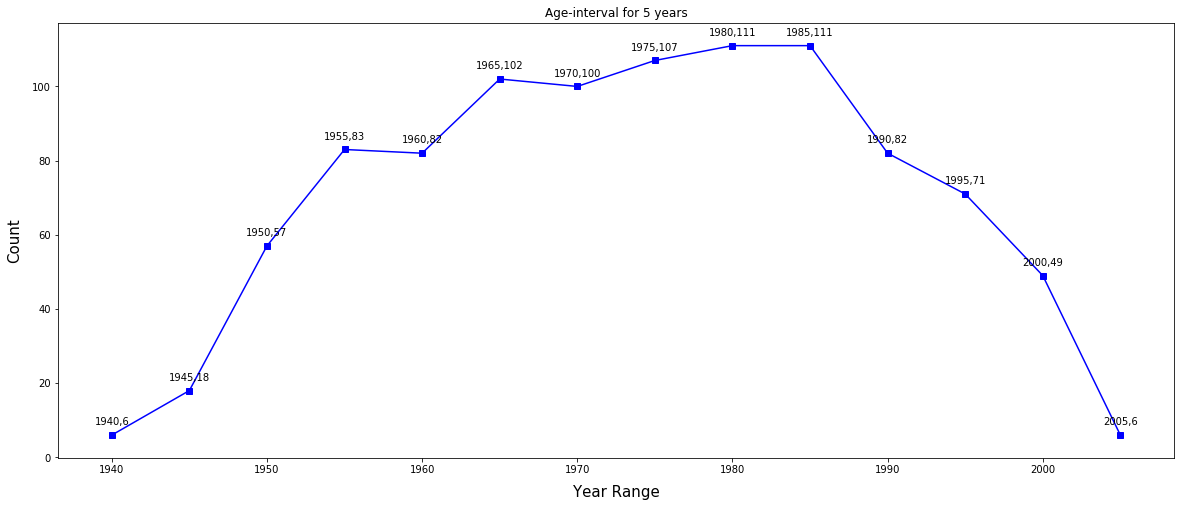

In [21]:
YearRange = []
for i in range(14):
    YearRange.append(len(taiwandata[taiwandata.YearRange.apply(lambda x: x == i)]))
    
x = [1940 + x * 5 for x in range(len(YearRange))]
y = YearRange

plt.figure(figsize = (20,8))
plt.plot(x, y, 's-', color = 'b', label = "Age-Interval")
plt.title("Age-interval for 5 years")
plt.xlabel("Year Range", fontsize = 15, labelpad = 10)
plt.ylabel("Count", fontsize = 15, labelpad = 10)

plt.scatter(x, y)

for i,j in zip(x, y):

    label = "{:.0f}".format(i) + "," + "{:.0f}".format(j)
    plt.annotate(label, # this is the text
                 (i, j), # this is the point to label
                 textcoords = "offset points", # how to position the text
                 xytext = (0,10), # distance from text to points (x,y)
                 ha = 'center') # horizontal alignment can be left, right or center

In [22]:
# SAVE RESAMPLE TAIWAN DATA INTO CSV FILE
resample_taiwandata.to_csv('EnglishResample_TaiwanFeatureData.csv', index = False)